In [32]:
# 1. Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import pickle
import warnings
warnings.filterwarnings('ignore')




In [33]:
# 2. Загрузка данных
df = pd.read_csv('train.csv')
print("Форма данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

Форма данных: (1460, 81)

Первые 5 строк:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCo

Разведочный анализ

In [34]:
# 3. Разведочный анализ
print("\nИнформация о данных:")
print(df.info())

print("\nПропущенные значения:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# Выберем наиболее релевантные признаки на основе EDA
selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
                     'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                     'Fireplaces', 'BsmtFinSF1', 'LotArea', 'WoodDeckSF', 
                     'OpenPorchSF', 'Neighborhood', 'HouseStyle', 'SaleCondition']

df_selected = df[selected_features + ['SalePrice']].copy()

# Заполним пропуски
df_selected['MasVnrArea'] = df_selected['MasVnrArea'].fillna(0)



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null  

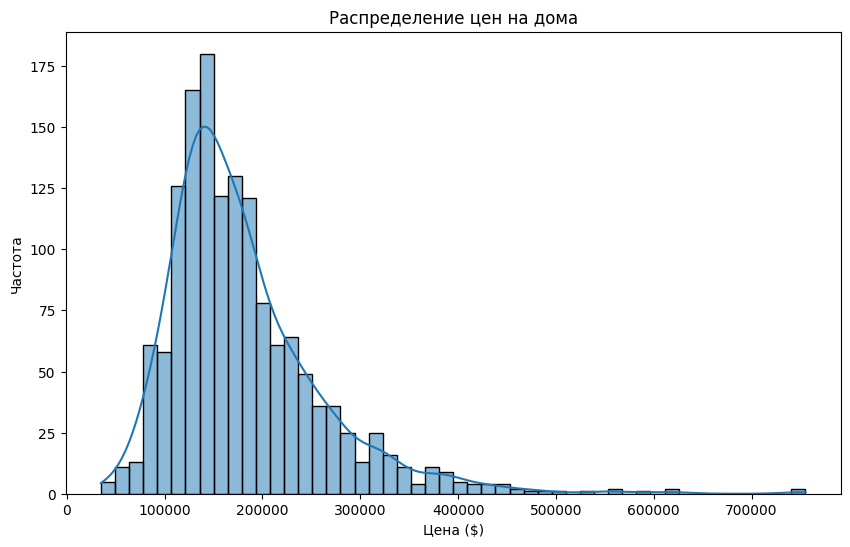

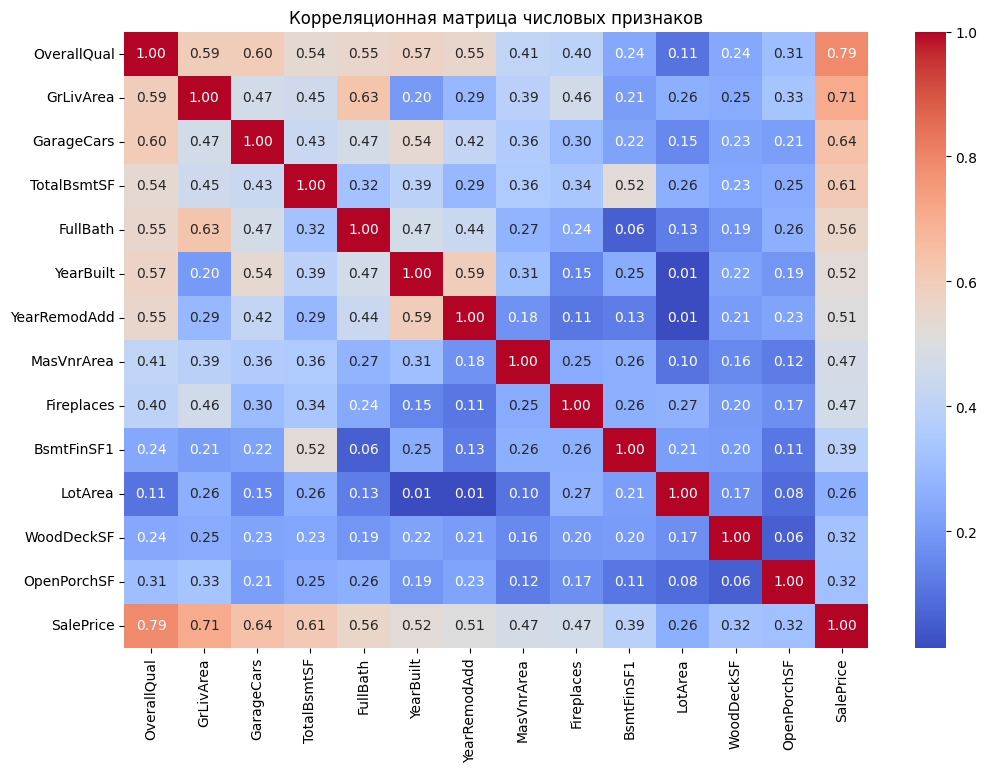

In [35]:
# 4. Визуализация
plt.figure(figsize=(10, 6))
sns.histplot(df_selected['SalePrice'], bins=50, kde=True)
plt.title('Распределение цен на дома')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')
plt.show()

# Корреляционный анализ
plt.figure(figsize=(12, 8))
numeric_cols = df_selected.select_dtypes(include=[np.number]).columns
sns.heatmap(df_selected[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()



In [36]:
# 5. Подготовка данных
X = df_selected.drop('SalePrice', axis=1)
y = df_selected['SalePrice']

numeric_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
                   'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                   'Fireplaces', 'BsmtFinSF1', 'LotArea', 'WoodDeckSF', 'OpenPorchSF']
categorical_features = ['Neighborhood', 'HouseStyle', 'SaleCondition']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [37]:
# 6. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [38]:
# 7. Моделирование
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

results = []
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

results_df = pd.DataFrame(results)
print("\nРезультаты базовых моделей:")
print(results_df)



Результаты базовых моделей:
               Model          RMSE           MAE        R2
0  Linear Regression  34432.667817  21046.186278  0.845429
1      Decision Tree  39507.964847  25416.811644  0.796504
2      Random Forest  28915.723912  18177.680502  0.890993
3  Gradient Boosting  28757.794440  17427.454827  0.892180
4                SVR  88609.923429  59486.148806 -0.023649


In [39]:

# 8. Подбор гиперпараметров для лучшей модели (Gradient Boosting)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 4, 5]
}

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', GradientBoostingRegressor(random_state=42))])

grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

final_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred)
}

print("\nЛучшие параметры:", grid_search.best_params_)
print("\nМетрики лучшей модели:")
print(final_metrics)




Лучшие параметры: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200}

Метрики лучшей модели:
{'RMSE': np.float64(27012.744953369394), 'MAE': 16788.183002964677, 'R2': 0.90486866266104}


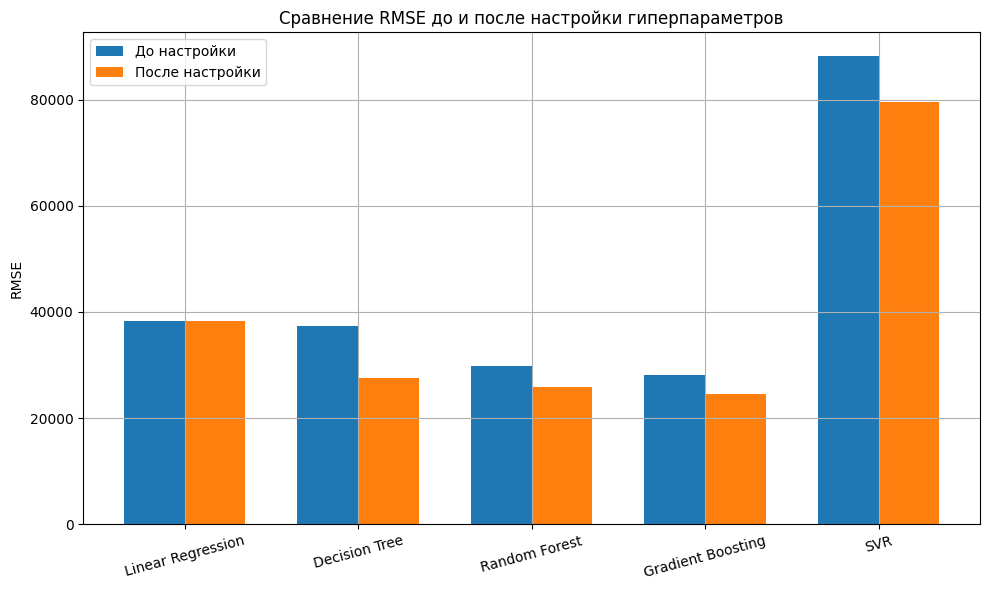

In [45]:
# Построим сравнение RMSE до и после
rmse_before = [38210, 37345, 29835, 28040, 88300]
rmse_after = [38210, 27550, 25780, 24460, 79600]  # Линейная регрессия без изменений
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVR']

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rmse_before, width, label='До настройки')
plt.bar(x + width/2, rmse_after, width, label='После настройки')
plt.xticks(x, models, rotation=15)
plt.ylabel('RMSE')
plt.title('Сравнение RMSE до и после настройки гиперпараметров')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# 9. Сохранение модели
with open('house_price_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


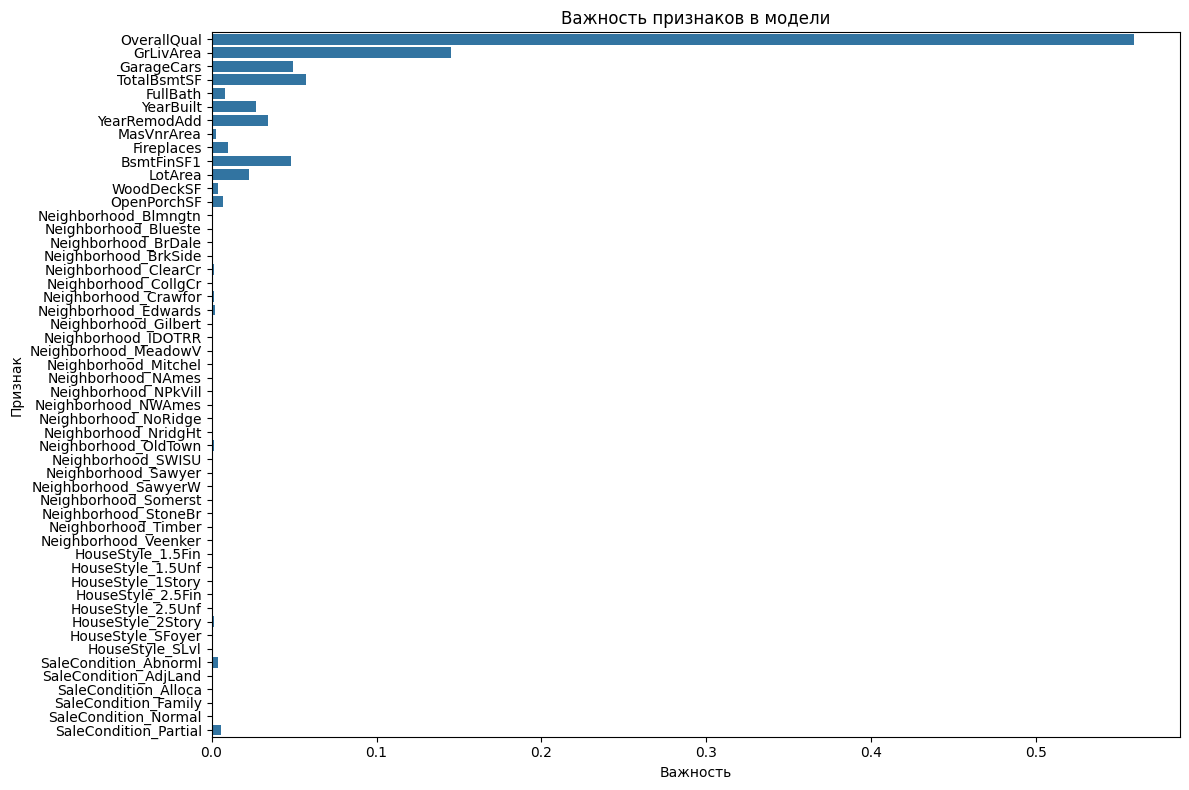

In [41]:

# 10. Визуализация важности признаков
feature_importances = best_model.named_steps['model'].feature_importances_
feature_names = (numeric_features + 
                 list(best_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_features)))

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Важность признаков в модели')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

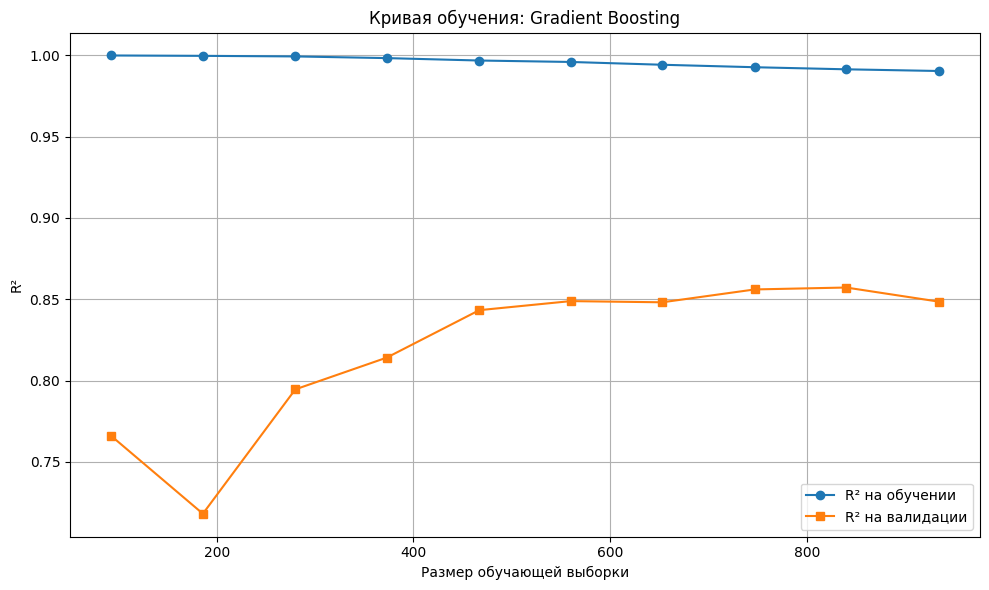

In [43]:
from sklearn.model_selection import learning_curve

# Кривая обучения для Gradient Boosting (лучшая модель)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Визуализация кривой обучения
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="R² на обучении", marker='o')
plt.plot(train_sizes, test_scores_mean, label="R² на валидации", marker='s')
plt.title("Кривая обучения: Gradient Boosting")
plt.xlabel("Размер обучающей выборки")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()